In [6]:
from typing import Any

from src.model_db.tiny_model_db import TinyModelDB

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from src.reinforcement_learning.algorithms.policy_mitosis.mitosis_policy_info import MitosisPolicyInfo
from src.model_db.model_db import ModelEntry
from src.trees import Forest


In [7]:
# with TinyModelDB(base_path=f'E:/saved_models/rl/MultiAgentCartPole/6/mitosis-2024-05-28_20.00.00', readonly=True) as policy_db:
with TinyModelDB(base_path=f'E:/saved_models/rl/Ant-v4/mitosis-2024-06-11_00.04.56', readonly=True) as policy_db:
    policy_entries_sorted: list[ModelEntry[MitosisPolicyInfo]] = list(sorted(policy_db.all_entries(), key=lambda p: p['model_info']['score'], reverse=True))

In [8]:


policy_info_forest = Forest(
    [pe["model_info"] for pe in policy_entries_sorted], 
    get_id=lambda pi: pi['policy_id'], 
    get_parent_id=lambda pi: pi['parent_policy_id']
)

for policy_entry in policy_entries_sorted:
    print(f"id = {policy_entry['model_id']}, "
          f"score = {policy_entry['model_info']['score']:6.4f}, "
          f"parent_id = {str(policy_entry['parent_model_id'])}, "
          f"disc_num_desc = {policy_info_forest.compute_num_descendants(policy_entry['model_id'], discount_factor=0.5)}"
    )

id = 2024-06-11_00.05.01~mAkq68, score = 42.0348, parent_id = None, disc_num_desc = 5.75
id = 2024-06-11_01.04.12~paLv3u, score = 37.4747, parent_id = 2024-06-11_00.24.13~VSXWXp, disc_num_desc = 3.0
id = 2024-06-11_01.14.12~HiSMRW, score = 37.4195, parent_id = 2024-06-11_01.04.12~paLv3u, disc_num_desc = 0.0
id = 2024-06-11_00.34.19~DAhxVk, score = 34.9794, parent_id = 2024-06-11_00.05.11~bJkJ9d, disc_num_desc = 2.0
id = 2024-06-11_00.05.11~bJkJ9d, score = 34.5020, parent_id = None, disc_num_desc = 7.5
id = 2024-06-11_00.05.21~lFXmGm, score = 33.9835, parent_id = None, disc_num_desc = 4.0
id = 2024-06-11_00.43.59~GPJytI, score = 31.0518, parent_id = 2024-06-11_00.05.11~bJkJ9d, disc_num_desc = 0.0
id = 2024-06-11_00.34.27~VMsuKo, score = 26.8800, parent_id = 2024-06-11_00.05.11~bJkJ9d, disc_num_desc = 2.0
id = 2024-06-11_00.05.16~YVmQmn, score = 26.2393, parent_id = None, disc_num_desc = 1.0
id = 2024-06-11_00.05.06~dbeTmK, score = 23.7270, parent_id = None, disc_num_desc = 2.5
id = 2024

In [9]:
from src.np_functions import softmax
steps_trained = np.array([policy_entry['model_info']['steps_trained'] for policy_entry in policy_entries_sorted])
steps_trained = steps_trained / steps_trained.mean()
softmax(-steps_trained, temperature=1.0)

array([0.03902138, 0.01522491, 0.00951001, 0.02437411, 0.03902138,
       0.03902138, 0.02437411, 0.02437411, 0.03902138, 0.03902138,
       0.02437411, 0.02437411, 0.02437411, 0.00951001, 0.02437411,
       0.02437411, 0.02437411, 0.01522491, 0.01522491, 0.02437411,
       0.00951001, 0.01522491, 0.03902138, 0.02437411, 0.03902138,
       0.01522491, 0.02437411, 0.02437411, 0.02437411, 0.03902138,
       0.01522491, 0.01522491, 0.01522491, 0.03902138, 0.01522491,
       0.03902138, 0.03902138, 0.02437411, 0.02437411, 0.01522491])

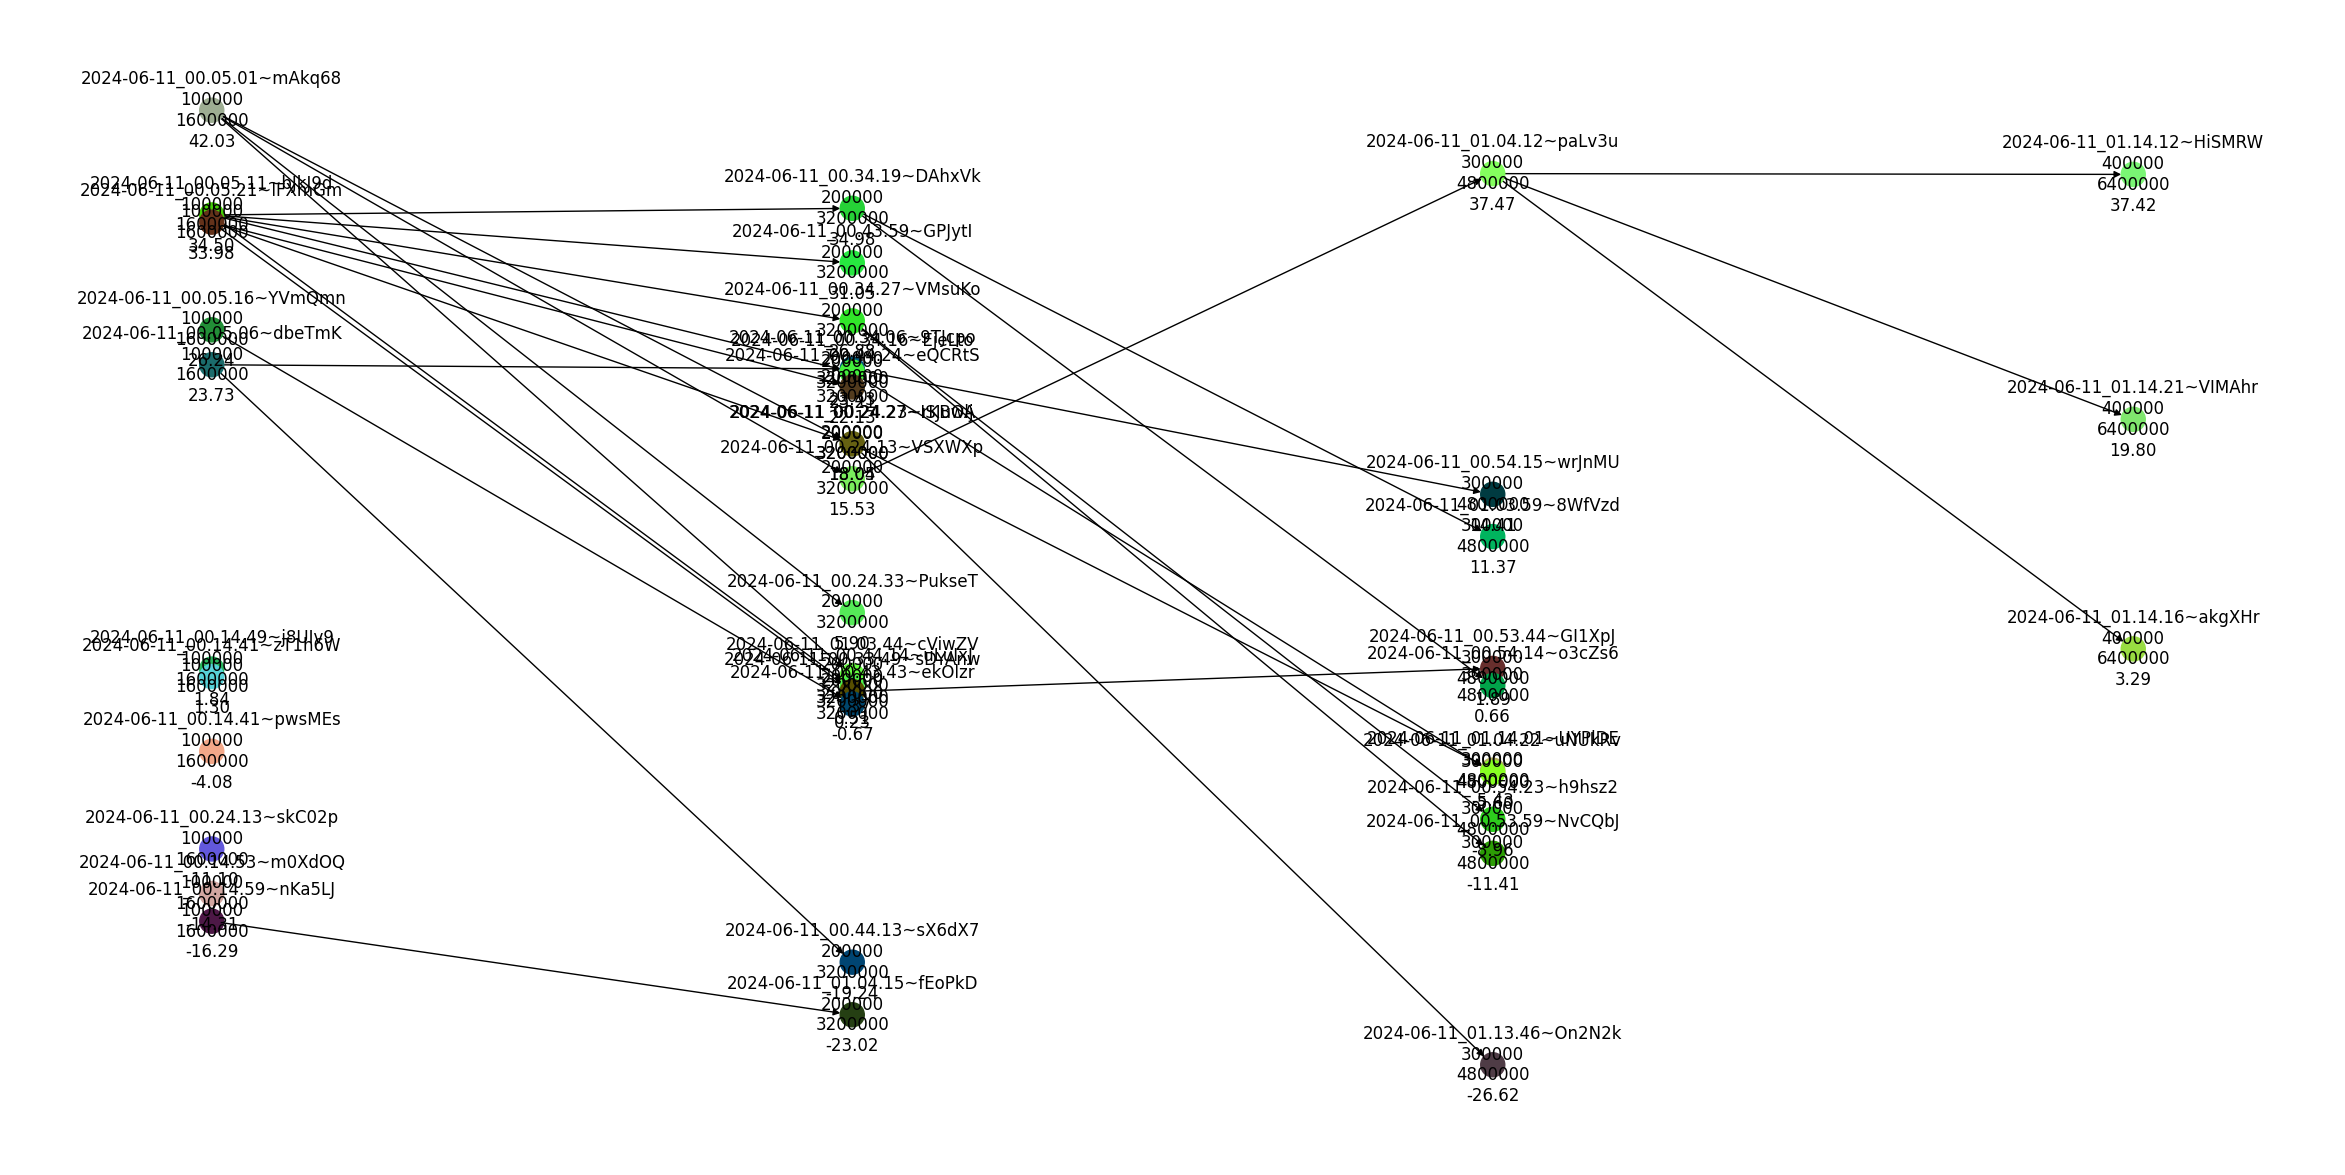

In [10]:
G = nx.DiGraph()

G.add_nodes_from(
    (policy_entry['model_id'], {
        'score': policy_entry['model_info']['score'], 
        'steps_trained': policy_entry['model_info']['steps_trained'],
        'env_steps_trained': policy_entry['model_info'].get('env_steps_trained', None)
    })
     for policy_entry 
     in policy_entries_sorted
     )

pos: dict[str, tuple[int, float]] = {}
for policy_entry in policy_entries_sorted:
    model_id = policy_entry['model_id']
    parent_id = policy_entry['parent_model_id']
    if parent_id is not None:
        G.add_edge(parent_id, model_id)
    
    model_info = policy_entry['model_info']
    pos[model_id] = (model_info['steps_trained'], model_info['score'])


def set_color_recursively(node_id: str, c: Any):
    colors[node_id] = c
    for neighbor_id in G.neighbors(node_id):
        c = np.clip(c + np.random.normal(loc=0, scale=0.1, size=3), 0, 1)
        set_color_recursively(neighbor_id, c)
    

colors: dict[str, np.ndarray] = {}
for root_id in (node for node, in_degree in G.in_degree() if in_degree == 0):
    color = list(np.random.random(3))
    set_color_recursively(root_id, color)

node_color = [colors[node_id] for node_id in G]

scores = nx.get_node_attributes(G, 'score')
steps_trained = nx.get_node_attributes(G, 'steps_trained')
env_steps_trained = nx.get_node_attributes(G, 'env_steps_trained')
labels: dict[str, str] = {}
for node_id, score in scores.items():
    labels[node_id] = f'{node_id}\n{steps_trained[node_id]}\n{env_steps_trained[node_id]}\n{score:.2f}'

fig, ax = plt.subplots(1, 1, figsize=(30, 15))
nx.draw(G, pos, with_labels=True, labels=labels, node_color=node_color, ax=ax)


In [8]:
model_id = '2024-06-10_19.53.09~66zYdZ'

def print_dict(d: dict):
    for key, value in d.items():
        if isinstance(value, dict):
            print(f"↓↓↓  {key:^15}  ↓↓↓")
            print_dict(value)
            print(f"↑↑↑  {key:^15}  ↑↑↑\n\n")
        else:
            print(f"======  {key:^15}  ======\n{value}\n")

print_dict(policy_db.fetch_entry(model_id))

ValueError: I/O operation on closed file.

In [3]:
policy_db.delete_entry('2024-04-30_09.24.10', delete_state_dict=True)

In [29]:
from src.np_functions import softmax
from typing import Iterable


def select_policy_selection_probs(policy_infos: Iterable[MitosisPolicyInfo]) -> np.ndarray:
    scores = np.array([policy_info['score'] for policy_info in policy_infos])
    scores = scores / scores.mean()
    scores = softmax(scores, temperature=0.9 / len(scores)**0.75)
    return scores

for a, b in zip([pe['model_info']['score'] for pe in policy_entries_sorted], select_policy_selection_probs([pe['model_info'] for pe in policy_entries_sorted])):
    print(f'{a:10.6f} | {b:10.6f}')

In [46]:

from tinydb import Query

# with TinyModelDB[MitosisPolicyInfo](base_path=f'E:/saved_models/rl/MultiAgentCartPole/6/mitosis-2024-05-28_20.00.00') as policy_db:
#     with TinyModelDB[MitosisPolicyInfo](base_path=f'E:/saved_models/rl/MultiAgentCartPole/6/mitosis-2024-05-28_20.00.00.backup_2024-06-01') as other_policy_db:
#         policy_db.copy_from(other_policy_db, entry_filter=lambda entry: entry['model_info']['score'] < 0.1)

In [3]:
from tinydb import Query

# with TinyModelDB[MitosisPolicyInfo](base_path=f'E:/saved_models/rl/MultiAgentCartPole/6/mitosis-2024-05-28_20.00.00') as policy_db:
#     policy_db.delete_entries(entry_filter=lambda entry: entry['model_info']['steps_trained'] < 300_000, delete_state_dict=True)